In [1]:
from data.load_all_datasets import load_data
from extractors.brute_force import extract_shapelet as bf_extractor
from extractors.fast_shapelets import extract_shapelet as fast_extractor
from extractors.sax_shapelets import extract_shapelet as sax_extractor
from extractors.extractor import SAXExtractor
from algorithms import ShapeletTreeClassifier, ShapeletTransformer
import time
from visualization import visualize_shapelet
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import util
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
import warnings; warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
def estimate_min_max(X, y, extractor, min_perc=25, max_perc=75, min_len=3, max_len=None, iterations=10):
    shapelet_lengths = []
    for _ in range(iterations):
        rand_idx = np.random.choice(range(len(X)), size=10, replace=False)
        X_sub = X[rand_idx, :]
        y_sub = y[rand_idx]
        shapelet_lengths += [len(x) for x in extractor.extract(X_sub, y_sub, min_len=min_len, max_len=max_len, nr_shapelets=10)]
        
    _min = int(np.percentile(shapelet_lengths, min_perc))
    _max = int(np.percentile(shapelet_lengths, max_perc))
    if _min == _max:
        _max += 1
    return _min, _max

In [3]:
data = sorted(load_data(), key=lambda x: x['n_samples']**2*x['n_features']**3)

In [7]:
i = 2

X = data[i]['data'].drop('target', axis=1)
y = data[i]['data'].loc[X.index, 'target']
map_dict = {}
for j, c in enumerate(np.unique(y)):
    map_dict[c] = j
y = y.map(map_dict) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1337)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print('Fitting shapelet transform on {} ({})'.format(data[i]['name'], X_train.shape))

extractor = SAXExtractor(alphabet_size=4, sax_length=16, nr_candidates=100, 
                         iterations=5, mask_size=3)

_min, _max = estimate_min_max(X_train, y_train, extractor, iterations=1, min_len=data[i]['n_features']//4, max_len=data[i]['n_features']//2)
#_min, _max = 12, 14
print(_min, _max)

length:   0%|          | 0/72 [00:00<?, ?it/s]

Fitting shapelet transform on Coffee ((28, 286))


length: 100%|██████████| 72/72 [15:03<00:00, 12.55s/it]

94 139


In [8]:
shap_transformer = ShapeletTransformer(method=extractor, min_len=_min, max_len=_max, nr_shapelets=data[i]['n_features']//2)
shap_tree_clf = ShapeletTreeClassifier(method=extractor, min_len=_min, max_len=_max)
shap_tree_clf.fit(X_train, y_train)
shapelets_from_tree = shap_tree_clf.tree.extract_all_shapelets()
print(shapelets_from_tree)

length: 100%|██████████| 45/45 [29:52<00:00, 39.83s/it]


[[0.8486899999999999, 0.86916, 0.89312, 0.94878, 0.94704, 0.97505, 0.9929100000000001, 1.0197, 0.9959100000000001, 0.90759, 0.73652, 0.61793, 0.57723, 0.53169, 0.53982, 0.47478000000000004, 0.35378000000000004, 0.34776999999999997, 0.38635, 0.33166, 0.27681999999999995, 0.25288, 0.27498, 0.33876, 0.36821, 0.45529, 0.5684, 0.66474, 0.77271, 0.81927, 0.8096, 0.74308, 0.73483, 0.8923200000000001, 0.9593, 0.9401799999999999, 0.8881, 0.92817, 0.9771299999999999, 0.97634, 0.94653, 0.7952, 0.7390100000000001, 0.7167399999999999, 0.71623, 0.6333300000000001, 0.58055, 0.61921, 0.6049800000000001, 0.60664, 0.63408, 0.50067, 0.34652, 0.25911, 0.15307, -0.001645, -0.12517, -0.20889000000000002, -0.26739, -0.25225, -0.20895999999999998, -0.19180999999999998, -0.18616, -0.18266, -0.06405599999999999, 0.038738999999999996, 0.12102, 0.16796, 0.14715, 0.091565, -0.001583, -0.075767, -0.11060999999999999, -0.018042, 0.093958, 0.19696, 0.24270999999999998, 0.28578000000000003, 0.35084, 0.3912, 0.51281999

In [9]:
shap_transformer.shapelets = shapelets_from_tree
X_distances_train = shap_transformer.transform(X_train)
X_distances_test = shap_transformer.transform(X_test)
rf = RandomForestClassifier(random_state=1337)
rf.fit(X_distances_train, y_train)

print('Confusion matrix using shapelets extracted from Shapelet Tree')
print(confusion_matrix(y_test, rf.predict(X_distances_test)))


shap_transformer.fit(X_train, y_train)
X_distances_train = shap_transformer.transform(X_train)
X_distances_test = shap_transformer.transform(X_test)

rf = RandomForestClassifier(random_state=1337)
rf.fit(X_distances_train, y_train)

print('Confusion matrix using shapelets extracted from single pass')
print(confusion_matrix(y_test, rf.predict(X_distances_test)))

length:   0%|          | 0/45 [00:00<?, ?it/s]

Confusion matrix using shapelets extracted from Shapelet Tree
[[14  0]
 [ 0 14]]


length: 100%|██████████| 45/45 [2:19:30<00:00, 186.00s/it]   


Confusion matrix using shapelets extracted from single pass
[[14  0]
 [ 2 12]]


In [10]:
print(len(shap_transformer.shapelets))

143


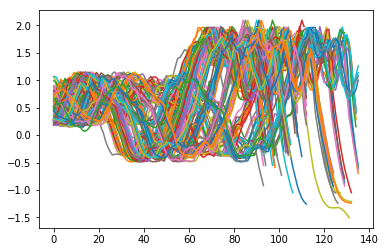

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
for shapelet in shap_transformer.shapelets:
    plt.plot(range(len(shapelet)), shapelet)
plt.show()

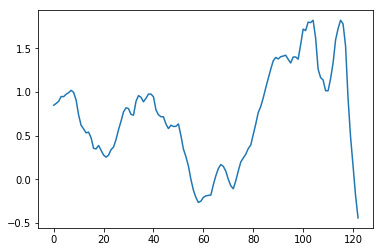

In [12]:
plt.figure()
for shapelet in shapelets_from_tree:
    plt.plot(range(len(shapelet)), shapelet)
plt.show()

### 